In [1]:
# You'll probably want to set our data rate higher for this notebook. 
# follow: http://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-when-viewing-image-in-jupyter-notebook

# Setup 
Let's setup our environment. We'll pull in the the usual gis suspects and setup a leaflet map, read our API keys from a json file, and setup our Planet client

In [2]:
# See requirements.txt to set up your dev environment.
import sys
import os
import json
import scipy
import urllib
import datetime 
import urllib3
import rasterio
import subprocess
import numpy as np
import pandas as pd
#import seaborn as sns
from osgeo import gdal
from planet import api
from planet.api import filters
from traitlets import link
import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline

# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
#os.environ["PL_API_KEY"] = ""
#api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=os.environ["PL_API_KEY"])


# Make a slippy map to get GeoJSON

* The planet API allows you to query using a [geojson](https://en.wikipedia.org/wiki/GeoJSON) which is a special flavor of json.
* We are going to create a slippy map using leaflet and apply the Planet 2017 Q1 mosaic as the basemap. This requires our api key.
* We are going to add a special draw handler that shoves a draw region into a object so we get the geojson.
* If you don't want to do this, or need a fixed query try [geojson.io](http://geojson.io/#map=2/20.0/0.0)
* To install and run:
```
$ pip install ipyleaflet
$ jupyter nbextension enable --py --sys-prefix ipyleaflet
$ jupyter nbextension enable --py --sys-prefix widgetsnbextension
```
* [More information](https://github.com/ellisonbg/ipyleaflet)

In [3]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + os.environ["PL_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [36.0988, -119.8815]
# Define initial map zoom level
zoom = 11
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

Map(center=[36.0988, -119.8815], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {'color': '#009da5'}}, polyline={'shapeOptions': {}}, rectangle={'shapeOptions': {'color': '#009da5'}}),), layers=(TileLayer(options=[u'opacity', u'attribution', u'max_zoom', u'detect_retina', u'min_zoom', u'tile_size'], url=u'https://tiles0.planet.com/experimental/mosaics/planet-tiles/global_quarterly_2017q1_mosaic/gmap/{z}/{x}/{y}.png?api_key=7cfe1cbf0b96466b9611bbdff4ceab4a'),), layout=Layout(align_self=u'stretch', height=u'400px'), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom'], zoom=11)

# Querying the Planet API.
* First we'll grab our geojson area of interest (AOI) and use it to construct a query.
* We'll then build a search to search that area looking for PSScene3Band
* We have lots of products: RapidEye, PlanetScope (PS) 3 and 4 band, LandSat, and Sentinel are all possible.
* Once we have our query, we'll do the search. We will then iterate over the results, slurp up the data, and put them in a pandas data frame for easy sorting.
* We'll print the first few so we're sure it works. 

In [4]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [-119.6147, 36.2116],
            [-119.5298, 35.2116],
            [-119.5298, 36.2981],
            [-119.6147, 36.2981],
            [-119.6147, 35.2116]
        ]
    ]
}


In [5]:
with open('../geojson_ROIs/kings_05.geojson') as f:
    aoi = json.load(f)
print(aoi)
myAOI = aoi
print(myAOI)

# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes

# define the date range for imagery
start_date = datetime.datetime(year=2016,month=1,day=1)
stop_date = datetime.datetime(year=2016,month=12,day=30)

query = filters.and_filter(
    filters.geom_filter(myAOI),
    filters.range_filter('cloud_cover', lt=5),
    filters.date_range('acquired', gt=start_date),
    filters.date_range('acquired', lt=stop_date)
)

# build a request for only RapidEye imagery
request = filters.build_search_request(
    query, item_types=['REOrthoTile']) 

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
display(scenes)
print len(scenes)

{u'type': u'Polygon', u'coordinates': [[[-119.6147, 36.2116], [-119.5298, 36.2116], [-119.5298, 36.2981], [-119.6147, 36.2981], [-119.6147, 36.2116]]]}
{u'type': u'Polygon', u'coordinates': [[[-119.6147, 36.2116], [-119.5298, 36.2116], [-119.5298, 36.2981], [-119.6147, 36.2981], [-119.6147, 36.2116]]]}


,acquired,anomalous_pixels,black_fill,catalog_id,cloud_cover,columns,epsg_code,geometry,grid_cell,ground_control,...,published,rows,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle
0,2016-12-27T19:11:43Z,0.00,0.00,29342881,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-12-29T20:33:33Z,5000,RapidEye-4,29345312,167.35620,29.53980,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T21:28:19Z,1.00,-3.18906
1,2016-12-03T19:09:34Z,0.35,0.34,29020380,0.01,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-12-05T21:18:18Z,5000,RapidEye-4,29021649,169.55531,30.93853,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T20:52:51Z,0.65,0.11954
2,2016-11-19T19:16:35Z,0.62,0.52,28833336,0.10,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-11-21T12:47:25Z,5000,RapidEye-4,28833975,172.30784,33.82838,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T20:35:49Z,0.38,-6.47766
3,2016-11-17T19:23:28Z,0.00,0.00,28825309,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-11-21T00:56:44Z,5000,RapidEye-2,28826084,174.32614,34.46198,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T20:33:04Z,1.00,3.45511
4,2016-11-13T19:11:51Z,0.00,0.00,28740210,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-11-14T16:43:02Z,5000,RapidEye-3,28745106,171.07443,35.17711,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T20:27:26Z,1.00,3.43051
5,2016-10-25T19:14:17Z,0.35,0.35,28455638,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-10-27T15:50:04Z,5000,RapidEye-3,28457938,170.97382,40.99741,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T20:04:55Z,0.65,3.43254
6,2016-10-14T19:27:58Z,0.15,0.04,28291173,0.11,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-10-16T12:01:21Z,5000,RapidEye-1,28291629,174.37848,45.20253,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T19:51:42Z,0.85,-9.68341
7,2016-10-06T19:16:27Z,0.17,0.17,28180864,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-10-07T19:02:44Z,5000,RapidEye-3,28188140,168.99699,47.80372,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T19:43:55Z,0.83,0.09768
8,2016-10-01T19:11:55Z,0.00,0.00,28105469,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-10-03T11:13:52Z,5000,RapidEye-3,28106767,166.24361,49.43912,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T19:35:34Z,1.00,6.73533
9,2016-09-25T19:30:05Z,0.06,0.06,28018830,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,2016-09-26T14:35:46Z,5000,RapidEye-1,28019929,172.01776,52.35706,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14T19:30:05Z,0.94,-9.63870


49


# Cleanup
* The data we got back is good, but we need some more information
* We got back big scenes, but we only care about our area of interest. The scene may not cover the whole area of interest.
* We can use the [Shapely](http://toblerity.org/shapely/manual.html) library to quickly figure out how much each scene overlaps our AOI
* We will convert our AOI and the geometry of each scene to calculate overlap using a shapely call.
* The returned acquisition, publish, and update times are strings, we'll convert them to datatime objects so we wan search.

In [6]:
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
ca_crop = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(ca_crop.intersection(s).area / ca_crop.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
scenes.head()

,acquired,anomalous_pixels,black_fill,catalog_id,cloud_cover,columns,epsg_code,geometry,grid_cell,ground_control,...,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle,overlap,footprint
0,2016-12-27 19:11:43,0.00,0.00,29342881,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-4,29345312,167.35620,29.53980,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 21:28:19,1.00,-3.18906,100.000000,"POLYGON ((-119.682017 36.4075897, -119.4034551..."
1,2016-12-03 19:09:34,0.35,0.34,29020380,0.01,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-4,29021649,169.55531,30.93853,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:52:51,0.65,0.11954,80.592610,POLYGON ((-119.5556126244229 36.41028298967947...
2,2016-11-19 19:16:35,0.62,0.52,28833336,0.10,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-4,28833975,172.30784,33.82838,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:35:49,0.38,-6.47766,71.255666,POLYGON ((-119.5750603414798 36.18455286058944...
3,2016-11-17 19:23:28,0.00,0.00,28825309,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-2,28826084,174.32614,34.46198,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:33:04,1.00,3.45511,100.000000,"POLYGON ((-119.682017 36.4075897, -119.4034551..."
4,2016-11-13 19:11:51,0.00,0.00,28740210,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-3,28745106,171.07443,35.17711,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:27:26,1.00,3.43051,100.000000,"POLYGON ((-119.682017 36.4075897, -119.4034551..."


# Filtering our search using pandas.
* Using our dataframe we will filter the scenes to just what we want.
* First we want scenes with less than 10% clouds.
* Second we want standard quality images. Test images may not be high quality.
* Third well only look for scenes since January.
* Finally we will create a new data frame with our queries and print the results. 

In [7]:
# Now let's get it down to just good, recent, clear scenes
clear = scenes['cloud_cover']<0.10
partial_coverage = scenes["overlap"] > 95
all_scenes = scenes[(clear&partial_coverage)]
display(all_scenes)

,acquired,anomalous_pixels,black_fill,catalog_id,cloud_cover,columns,epsg_code,geometry,grid_cell,ground_control,...,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle,overlap,footprint
0,2016-12-27 19:11:43,0.00,0.00,29342881,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-4,29345312,167.35620,29.53980,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 21:28:19,1.00,-3.18906,100.0,"POLYGON ((-119.682017 36.4075897, -119.4034551..."
3,2016-11-17 19:23:28,0.00,0.00,28825309,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-2,28826084,174.32614,34.46198,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:33:04,1.00,3.45511,100.0,"POLYGON ((-119.682017 36.4075897, -119.4034551..."
4,2016-11-13 19:11:51,0.00,0.00,28740210,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-3,28745106,171.07443,35.17711,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:27:26,1.00,3.43051,100.0,"POLYGON ((-119.682017 36.4075897, -119.4034551..."
5,2016-10-25 19:14:17,0.35,0.35,28455638,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-3,28457938,170.97382,40.99741,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 20:04:55,0.65,3.43254,100.0,POLYGON ((-119.5294284281789 36.18552009583164...
7,2016-10-06 19:16:27,0.17,0.17,28180864,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-3,28188140,168.99699,47.80372,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 19:43:55,0.83,0.09768,100.0,POLYGON ((-119.4768905437904 36.18663371324664...
8,2016-10-01 19:11:55,0.00,0.00,28105469,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-3,28106767,166.24361,49.43912,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 19:35:34,1.00,6.73533,100.0,"POLYGON ((-119.682017 36.4075897, -119.4034551..."
9,2016-09-25 19:30:05,0.06,0.06,28018830,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-1,28019929,172.01776,52.35706,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 19:30:05,0.94,-9.63870,100.0,POLYGON ((-119.4024454421468 36.38058717237804...
11,2016-09-09 19:13:15,0.00,0.00,27799557,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-5,27800484,160.35166,57.35520,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 19:08:47,1.00,6.77770,100.0,"POLYGON ((-119.681349475688 36.40760392289642,..."
12,2016-09-08 19:09:28,0.26,0.26,27781453,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-4,27784312,158.32053,57.42387,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 19:07:48,0.74,6.71509,100.0,POLYGON ((-119.5866737061164 36.40962117326389...
13,2016-09-06 19:32:12,0.34,0.34,27736761,0.00,5000,32611,"{u'type': u'Polygon', u'coordinates': [[[-119....",1155805,NaN,...,RapidEye-1,27738875,168.17955,59.43602,https://api.planet.com/data/v1/item-types/REOr...,2017-04-14 19:04:15,0.66,-9.79264,100.0,POLYGON ((-119.5229160120636 36.18565813603033...


36


# Visualizing scene foot prints overlap with our AOI
* We know these scenes intersect with our AOI, but we aren't quite sure about the geometry.
* We are going to plot our scene footprints and original AOI on our slippy map.
* To do this we create GeoJson objects with properties. 

In [8]:
# first create a list of colors
colors = ["#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff"]
# grab our scenes from the geometry/footprint geojson
footprints = all_scenes["geometry"].tolist()
# for each footprint/color combo
for footprint,color in zip(footprints,colors):
    # create the leaflet object
    feat = {'geometry':footprint,"properties":{
            'style':{'color': color,'fillColor': color,'fillOpacity': 0.2,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
# now we will draw our original AOI on top 
feat = {'geometry':myAOI,"properties":{
            'style':{'color': "#FFFFFF",'fillColor': "#FFFFFF",'fillOpacity': 0.5,'weight': 1}},
            'type':u"Feature"}
gjson = GeoJSON(data=feat)
m.add_layer(gjson)   
m 


Map(center=[36.09904766316007, -119.8817825317383], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {'color': '#009da5'}}, polyline={'shapeOptions': {}}, rectangle={'shapeOptions': {'color': '#009da5'}}),), layers=(TileLayer(options=[u'opacity', u'attribution', u'max_zoom', u'detect_retina', u'min_zoom', u'tile_size'], url=u'https://tiles0.planet.com/experimental/mosaics/planet-tiles/global_quarterly_2017q1_mosaic/gmap/{z}/{x}/{y}.png?api_key=7cfe1cbf0b96466b9611bbdff4ceab4a'), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.682017, 36.4075897], [-119.4034551, 36.413525], [-119.3965523, 36.1883366], [-119.6743156, 36.182449], [-119.682017, 36.4075897]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#ff0000', 'fillColor': '#ff0000', 'weight': 1, 'fillOpacity': 0.2}}}), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.682017, 36.4075897], [-119.4034551, 36.413525], [-119.3965523, 36.1883366], [-119.6743156, 36.182449], [-119.682017, 36.4075897]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#00ff00', 'fillColor': '#00ff00', 'weight': 1, 'fillOpacity': 0.2}}}), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.682017, 36.4075897], [-119.4034551, 36.413525], [-119.3965523, 36.1883366], [-119.6743156, 36.182449], [-119.682017, 36.4075897]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#0000ff', 'fillColor': '#0000ff', 'weight': 1, 'fillOpacity': 0.2}}}), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.5294284281789, 36.18552009583164], [-119.6743156, 36.182449], [-119.682017, 36.4075897], [-119.46586989157447, 36.41219513215938], [-119.49089921545, 36.3231884932609], [-119.5294284281789, 36.18552009583164]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#ffff00', 'fillColor': '#ffff00', 'weight': 1, 'fillOpacity': 0.2}}}), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.47689054379039, 36.186633713246636], [-119.6743156, 36.182449], [-119.682017, 36.4075897], [-119.41207704174022, 36.413341292856956], [-119.43175417421, 36.3447284248642], [-119.47689054379039, 36.186633713246636]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#ff00ff', 'fillColor': '#ff00ff', 'weight': 1, 'fillOpacity': 0.2}}}), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.682017, 36.4075897], [-119.4034551, 36.413525], [-119.3965523, 36.1883366], [-119.6743156, 36.182449], [-119.682017, 36.4075897]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#00ffff', 'fillColor': '#00ffff', 'weight': 1, 'fillOpacity': 0.2}}}), GeoJSON(data={'geometry': {u'type': u'Polygon', u'coordinates': [[[-119.6147, 36.2116], [-119.5298, 36.2116], [-119.5298, 36.2981], [-119.6147, 36.2981], [-119.6147, 36.2116]]]}, 'type': u'Feature', 'properties': {'style': {'color': '#FFFFFF', 'fillColor': '#FFFFFF', 'weight': 1, 'fillOpacity': 0.5}}})), layout=Layout(align_self=u'stretch', height=u'400px'), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom'], zoom=11)

# Let's see what we got. 
* The API returns a handy thumbnail link.
* Let's tell jupyter to show it.
* You may need to login to planet explorer to have auth. 
    * If this is the case just print the urls and paste them into your browser.

In [9]:
imgs = []
# loop through our thumbnails and add display them
for img in all_scenes["thumbnail"].tolist():
    imgs.append(Image(url=img))
    print img
display(*imgs)

https://api.planet.com/data/v1/item-types/REOrthoTile/items/20161227_191143_1155805_RapidEye-4/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20161117_192328_1155805_RapidEye-2/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20161113_191151_1155805_RapidEye-3/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20161025_191417_1155805_RapidEye-3/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20161006_191627_1155805_RapidEye-3/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20161001_191155_1155805_RapidEye-3/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20160925_193005_1155805_RapidEye-1/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20160909_191315_1155805_RapidEye-5/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20160908_190928_1155805_RapidEye-4/thumb
https://api.planet.com/data/v1/item-types/REOrthoTile/items/20160906_193212_1155805_RapidEy

# Product Activation and Downloading
* There are two things we need to know, the satellite type (asset) and image type (product).
* Full resolution uncompressed satellite images are *big* and there are lots of ways to view them.
* For this reason Planet generally keeps images in their native format and only processes them on customer requests. There is some caching of processed scenes, but this is the exception not the rule.
* All images must be activated prior to downloading and this can take some time based on demand.
* Additionally we need to determine what sort of product we want to download. Generally speaking there are three kinds of scenes:
    * Analytic - multi-band full resolution images that have not been processed. These are like raw files for DSLR camers.
    * Visual - these are color corrected rectified tifs. If you are just starting out this is your best call.
    * UDM - Usable data mask. This mask can be used to find bad pixels and columns and to mask out areas with clouds.
    

In [10]:
def get_products(client, scene_id, asset_type='REOrthoTile'):
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="REOrthoTile",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print "{} is not ready.".format(scene)
            return False
    return True

# Scenes ACTIVATE!
* Given our good scenes list we will convert the data frame "id" column into a list and activate every item in that list. 
* For this example we are going to default to using a 3Band visual product but I have included some four band methods to help you out.
* Activation usually takes about 5-15 minutes so get some coffee.

In [11]:
to_get = all_scenes["id"].tolist()

In [12]:
activated = []
# for each scene to get
for scene in to_get:
    # get the product 
    product_types = get_products(client,scene)
    for p in product_types:
        # if there is a visual product
        if p == "analytic": # p == "basic_analytic_dn"
            print "Activating {0} for scene {1}".format(p,scene)
            # activate the product
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

Activating analytic for scene 20161227_191143_1155805_RapidEye-4
Activating analytic for scene 20161117_192328_1155805_RapidEye-2
Activating analytic for scene 20161113_191151_1155805_RapidEye-3
Activating analytic for scene 20161025_191417_1155805_RapidEye-3
Activating analytic for scene 20161006_191627_1155805_RapidEye-3
Activating analytic for scene 20161001_191155_1155805_RapidEye-3
Activating analytic for scene 20160925_193005_1155805_RapidEye-1
Activating analytic for scene 20160909_191315_1155805_RapidEye-5
Activating analytic for scene 20160908_190928_1155805_RapidEye-4
Activating analytic for scene 20160906_193212_1155805_RapidEye-1
Activating analytic for scene 20160824_191549_1155805_RapidEye-3
Activating analytic for scene 20160823_192237_1155805_RapidEye-2
Activating analytic for scene 20160405_192008_1155805_RapidEye-5
Activating analytic for scene 20160404_191636_1155805_RapidEye-4
Activating analytic for scene 20160502_192456_1155805_RapidEye-3
Activating analytic for s

# Download Scenes
* In this section we will see if our scenes have been activated.
* If they are activated the client object will have its status flag set to active.
* Once that is done we will then save the scenes to the local directory.
* A smart engineer would set a path variable to store these files and check if the asset has already been downloaded prior to downloading

In [13]:
tiff_files = []
asset_type = "_4B_Analytic"
# check if our scenes have been activated
if True: #scenes_are_active(activated):
    for to_download,name in zip(activated,to_get):
        # create the product name
        name = name + asset_type + ".tif"
        # if the product exists locally
        if( os.path.isfile(name) ):
            # do nothing 
            print "We have scene {0} already, skipping...".format(name)
            tiff_files.append(name)
        elif to_download["status"] == "active":
            # otherwise download the product
            print "Downloading {0}....".format(name)
            fname = download_and_save(client,to_download)
            tiff_files.append(fname)
            print "Download done."
        else:
            # print(to_download["status"])
            print "Could not download, still activating"
else:
    print "Scenes aren't ready yet"

print tiff_files 
        

Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
Download done.
['1155805_2016-12-27_RE4_3A.tif', '1155805_2016-11-17_RE2_3A.tif', '1155805_2016-11-13_RE3_3A.tif', '1155805_2016-10-25_RE3_3A.tif', '1155805_2016-10-06_RE3_3A.tif', '1155805_2016-10-01_RE3_3A.tif', '1155805_2016-09-25_RE1_3A.tif', '1155805_2016-09-09_RE5_3A.tif', '1155805_2016-09-08_RE4_3A.tif', '1155805_2016-09-06_RE1_3A.tif', '1155805_2016-08-24_RE3_3A.tif', '1155805_2016-08-23_RE2_3A.tif', '1155805_2016-04-05_RE5_3A.tif', '1155805_2016-04-04_RE4_3A.tif

# Loading Images
* There are a varitety of ways to load tif data including Rasterio, GDAL, OpenCV, SKImage. 
* Today we are going to use rasterio and load each channel into a numpy array.
* Since the visual 3Band products are rotated we can also open a mask layer for processing.

In [14]:
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])
        
def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([b, g, r])
        
def get_mask(filename):
    """Return a 1D mask numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([mask])

def rgbir_to_rgb(img_4band):
    """Convert an RGBIR image to RGB"""
    return img_4band[:,:,:3]

# Read Images and Use Matplotlib to show them.

In [13]:
img_files = []
masks = []
# load the images and masks
for fname in tiff_files[0:2]:
    img_files.append(load_image4(fname))
    masks.append(get_mask(fname))

# Quick Histogram
* Next up we'll plot the histogram of the image.
* A histogram is just a plot of the number of pixels with a specific intensity for a given color. 

In [14]:
import numpy.ma as ma
def plot_hist4(img_4band,title=""):
    # Plot a four band histogram
    r, g, b, nir = img_4band[:, :, 0], img_4band[:, :, 1], img_4band[:, :, 2], img_4band[:, :, 3]
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,img_4band.max()], 
                 label=name, color=color, histtype='step')
    plt.title(title)
    plt.legend()
    
def plot_hist3(img_3band,mask,title=""):
    # plot a three band histogramwaiter = []
    r, g, b = img_3band[:, :, 0], img_3band[:, :, 1], img_3band[:, :, 2]
    r = ma.masked_array(r,mask=mask)
    g = ma.masked_array(g,mask=mask)
    b = ma.masked_array(b,mask=mask)
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=25, 
                 range=[0,img_3band.max()], 
                 label=name, color=color, histtype='step')
    plt.title(title)
    plt.legend()

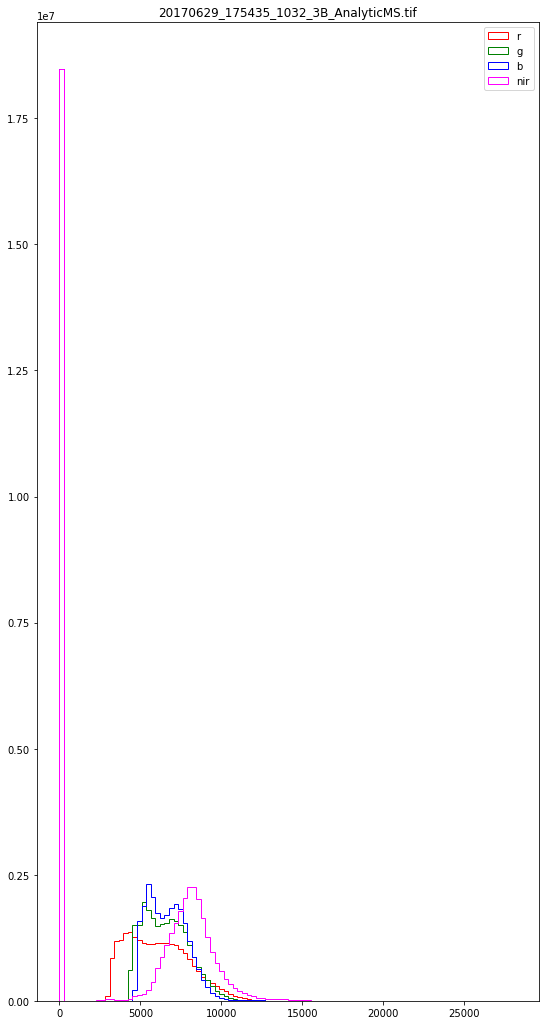

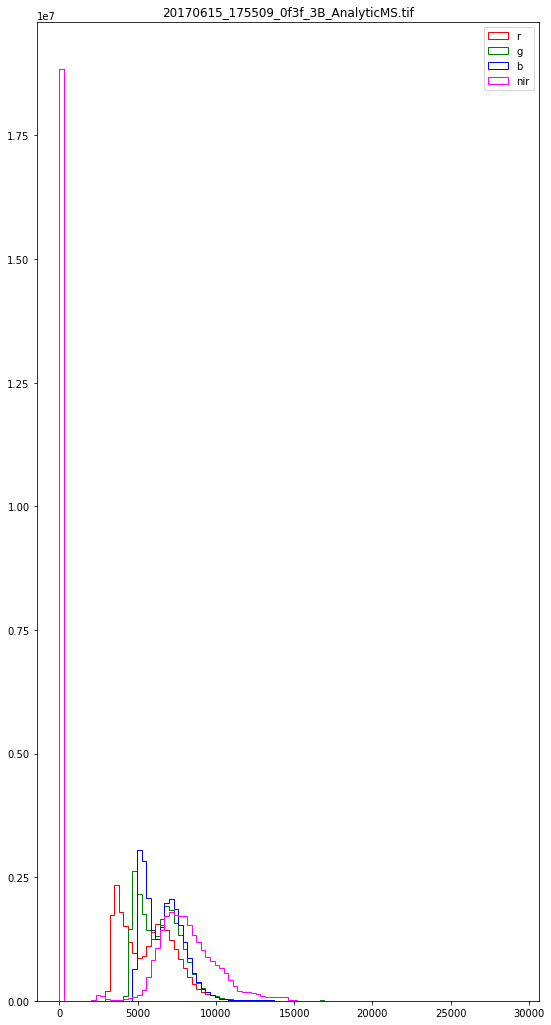

In [16]:
i = 0
for img,name,mask in zip(img_files,tiff_files,masks):
    plt.figure(i,figsize=(9,18))
    #plot_hist4(img,mask=mask,title=name)
    plot_hist4(img,title=name)
    i+=1

# Decomposing Channels
* We can also decompose the channels of the image. 
* Sometimes it is useful to work just in a single channel.
* Other times channels can be used to do useful things, like filter out clouds.


In [18]:
def plot_bands4(img,title="",i=0):
    fig = plt.figure(i)
    fig.set_size_inches(24, 3)
    r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    fig.suptitle(title)
    for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(c)
        plt.imshow(x)
        
def plot_bands3(img,title="",i=0):
    fig = plt.figure(i)
    fig.set_size_inches(24, 5)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    fig.suptitle(title)
    for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(c)
        plt.imshow(x)        

In [19]:
plot_bands4(img_files[0],title=tiff_files[0],i=0)

NameError: name 'img_files' is not defined

In [ ]:
# But all of these scenes are big, and we want only data within the AOI
* We can clip all of the scenes to the AOI we selected at the start of the notebook
* First we'll dump the geojson to a file.
* Since geospatial data is "big" we often work with files and get stuff out of memory ASAP.
* For each of our scenes we'll create a 'clip' file.
* We will use a tool called GDAL to clip the scene to our AOI
* GDAL stands for [Geospatial Data Abstraction Library](http://www.gdal.org/)
* GDAL is a C++ library that is often run from the command line, but it does have SWIG bindings.

In [22]:
import glob, os
tiff_files = []
for file in glob.glob("*.tif"):
    tiff_files.append(file)
print(tiff_files)

['1155704_2016-07-07_RE2_3A.tif', '1155704_2016-08-23_RE2_3A.tif', '1155704_2016-09-06_RE1_3A.tif', '1155704_2016-09-09_RE5_3A.tif']


In [15]:
aoi_file = '../geojson_ROIs/kings_05.geojson' 
# write our input AOI to a geojson file.
with open(aoi_file,"w") as f:
    f.write(json.dumps(myAOI))
    
# create our full input and output names
clip_names = [os.path.abspath(tiff[:-4]+"_clip"+".tif") for tiff in tiff_files]
full_tif_files = [os.path.abspath("./"+tiff) for tiff in tiff_files]

for in_file,out_file in zip(tiff_files,clip_names):
    commands = ["gdalwarp", # t
           "-t_srs","EPSG:3857",
           "-cutline",aoi_file,
           "-crop_to_cutline",
           "-tap",
            "-tr", "3", "3"
           "-overwrite"]
    subprocess.call(["rm",out_file])
    commands.append(in_file)
    commands.append(out_file)
    print " ".join(commands)
    subprocess.call(commands)

gdalwarp -t_srs EPSG:3857 -cutline ../geojson_ROIs/kings_05.geojson -crop_to_cutline -tap -tr 3 3-overwrite 1155805_2016-12-27_RE4_3A.tif /home/jovyan/work/temporal-crop-classification/notebooks/1155805_2016-12-27_RE4_3A_clip.tif
gdalwarp -t_srs EPSG:3857 -cutline ../geojson_ROIs/kings_05.geojson -crop_to_cutline -tap -tr 3 3-overwrite 1155805_2016-11-17_RE2_3A.tif /home/jovyan/work/temporal-crop-classification/notebooks/1155805_2016-11-17_RE2_3A_clip.tif
gdalwarp -t_srs EPSG:3857 -cutline ../geojson_ROIs/kings_05.geojson -crop_to_cutline -tap -tr 3 3-overwrite 1155805_2016-11-13_RE3_3A.tif /home/jovyan/work/temporal-crop-classification/notebooks/1155805_2016-11-13_RE3_3A_clip.tif
gdalwarp -t_srs EPSG:3857 -cutline ../geojson_ROIs/kings_05.geojson -crop_to_cutline -tap -tr 3 3-overwrite 1155805_2016-10-25_RE3_3A.tif /home/jovyan/work/temporal-crop-classification/notebooks/1155805_2016-10-25_RE3_3A_clip.tif
gdalwarp -t_srs EPSG:3857 -cutline ../geojson_ROIs/kings_05.geojson -crop_to_cut

In [5]:
import glob, os
clip_names = []
for file in glob.glob("*clip.tif"):
    clip_names.append(file)
print(clip_names)

['20170504_175202_1010_3B_AnalyticMS_clip.tif', '20170516_175941_0e1f_3B_AnalyticMS_clip.tif', '20170519_175240_102d_3B_AnalyticMS_clip.tif', '20170522_175316_0f25_3B_AnalyticMS_clip.tif', '20170522_175317_0f25_3B_AnalyticMS_clip.tif', '20170527_175411_103d_3B_AnalyticMS_clip.tif', '20170530_175345_1015_3B_AnalyticMS_clip.tif', '20170601_175339_0f12_3B_AnalyticMS_clip.tif', '20170601_175340_0f12_3B_AnalyticMS_clip.tif', '20170608_175433_1039_3B_AnalyticMS_clip.tif', '20170608_175434_1039_3B_AnalyticMS_clip.tif', '20170609_175429_1006_3B_AnalyticMS_clip.tif', '20170609_175430_1006_3B_AnalyticMS_clip.tif', '20170614_175420_0f52_3B_AnalyticMS_clip.tif', '20170615_175429_1022_3B_AnalyticMS_clip.tif', '20170615_175430_1022_3B_AnalyticMS_clip.tif', '20170615_175509_0f3f_3B_AnalyticMS_clip.tif', '20170615_175947_0e30_3B_AnalyticMS_clip.tif', '20170615_175948_0e30_3B_AnalyticMS_clip.tif', '20170616_175415_102f_3B_AnalyticMS_clip.tif', '20170616_175416_102f_3B_AnalyticMS_clip.tif', '20170617_17

# Awesome, Let's take a look at what we got.

In [23]:
print(clip_names[0:10])

['/home/jovyan/work/temporal-crop-classification/20170504_175417_1023_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170508_180053_0e30_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170607_175557_1030_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170607_180227_0e16_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170616_175613_1025_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170618_180242_0e1f_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170619_175714_0f17_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170620_175604_1021_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170622_175646_1015_3B_AnalyticMS_clip.tif', '/home/jovyan/work/temporal-crop-classification/20170625_175645_102c_3B_AnalyticMS_clip.tif']


In [24]:
clip_names = clip_names[0:10]
clip_img_files = [load_image4(fname) for fname in clip_names]
    

<img src="./XXX.gif">